<a href="https://colab.research.google.com/github/kleofas97/Biometrics/blob/main/lab2/Fake_vs_Original_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders

In [2]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
import splitfolders
import numpy as np
import cv2
import os

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adammika","key":"e7d62e5b1bd17724efe523a33f035198"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggleDownloader
from kaggleDownloader import get_dataset
get_dataset("kaggle datasets download -d ciplab/real-and-fake-face-detection")


Download completed..
Unzipping the zip files

Zip Files unzipped

 Directory contains the following files :  ['.config', 'real_and_fake_face_detection', 'real-and-fake-face-detection.zip', 'kaggle.json', 'real_and_fake_face', 'sample_data']

Remove zip files ? (yes/no) :yes

 Directory contains the following files :  ['.config', 'real_and_fake_face_detection', 'kaggle.json', 'real_and_fake_face', 'sample_data']


In [10]:
print(os.listdir())
print(os.getcwd())

['.config', 'real_and_fake_face_detection', 'kaggle.json', 'real_and_fake_face', 'sample_data']
/content


In [11]:
real = "/content/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "/content/real_and_fake_face_detection/real_and_fake_face/training_fake/"
real_path = os.listdir(real)
fake_path = os.listdir(fake)
print(len(real_path))

1081


In [12]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    return image[...,::-1]

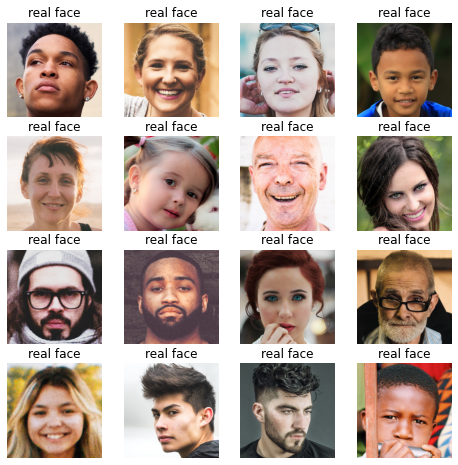

In [14]:
fig = plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.title("real face")
    plt.axis('off')

plt.show()

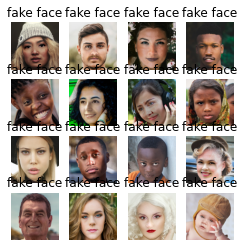

In [15]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.title("fake face")
    plt.axis('off')

plt.show()

In [32]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.2
                                   )

In [33]:
dataset_path = "/content/real_and_fake_face_detection/real_and_fake_face"

In [34]:
train = train_datagen.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=128,
                                          subset="training"
                                         )

Found 1633 images belonging to 2 classes.


In [36]:
val = train_datagen.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=128,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


In [37]:
mobilenetV2 = MobileNetV2(input_shape=(96, 96, 3),
                          include_top=False,
                          weights='imagenet'
                          )

average_layer = GlobalAveragePooling2D()

model = Sequential([
    mobilenetV2,
    average_layer,
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation=tf.nn.softmax)
])

In [51]:
model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 2,587,458
Trainable params: 328,962
Non-trainable params: 2,258,496
______________________________________

In [52]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 7:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)
hist = model.fit(train,
                epochs=10,
                callbacks=[lr_callbacks],
                validation_data=val)

Epoch 1/10
13/13 [==============================] - 24s 2s/step - loss: 0.1722 - accuracy: 0.9365 - val_loss: 1.3957 - val_accuracy: 0.5270
Epoch 2/10
13/13 [==============================] - 21s 2s/step - loss: 0.1556 - accuracy: 0.9404 - val_loss: 1.2565 - val_accuracy: 0.5123
Epoch 3/10
13/13 [==============================] - 21s 2s/step - loss: 0.1111 - accuracy: 0.9678 - val_loss: 1.2169 - val_accuracy: 0.5270
Epoch 4/10
13/13 [==============================] - 21s 2s/step - loss: 0.0977 - accuracy: 0.9704 - val_loss: 1.2019 - val_accuracy: 0.5196
Epoch 5/10
13/13 [==============================] - 20s 2s/step - loss: 0.0876 - accuracy: 0.9787 - val_loss: 1.2381 - val_accuracy: 0.5098
Epoch 6/10
13/13 [==============================] - 21s 2s/step - loss: 0.0728 - accuracy: 0.9837 - val_loss: 1.2604 - val_accuracy: 0.5123
Epoch 7/10
13/13 [==============================] - 21s 2s/step - loss: 0.0693 - accuracy: 0.9820 - val_loss: 1.2729 - val_accuracy: 0.5172
Epoch 8/10
13/13 [==

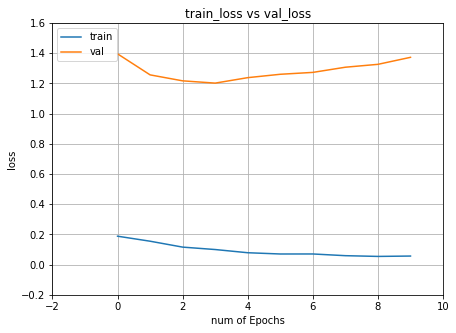

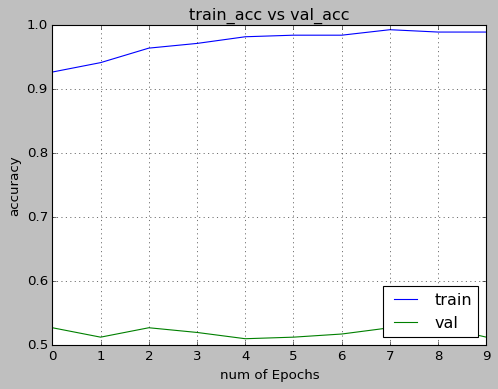

In [53]:
epochs = 10
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [55]:
train = train_datagen.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = train_datagen.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [69]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [73]:

model = Sequential([vgg16_model,
                    tensorflow.keras.layers.Flatten(),
                    Dense(256, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(64, activation = "relu"),
                    Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               6422784   
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)              

In [74]:
hist =  model.fit(train,
                    epochs=10,
                    callbacks=[lr_callbacks],
                    validation_data=val)

Epoch 1/10
17/17 [==============================] - 54s 2s/step - loss: 1.0069 - accuracy: 0.5902 - val_loss: 1.0954 - val_accuracy: 0.5564
Epoch 2/10
17/17 [==============================] - 24s 1s/step - loss: 0.6274 - accuracy: 0.6850 - val_loss: 1.4320 - val_accuracy: 0.5270
Epoch 3/10
17/17 [==============================] - 24s 1s/step - loss: 0.5486 - accuracy: 0.7494 - val_loss: 1.4535 - val_accuracy: 0.5025
Epoch 4/10
17/17 [==============================] - 24s 1s/step - loss: 0.5148 - accuracy: 0.7420 - val_loss: 1.1902 - val_accuracy: 0.5221
Epoch 5/10
17/17 [==============================] - 24s 1s/step - loss: 0.4954 - accuracy: 0.7505 - val_loss: 1.0977 - val_accuracy: 0.5490
Epoch 6/10
17/17 [==============================] - 24s 1s/step - loss: 0.5142 - accuracy: 0.7571 - val_loss: 1.0153 - val_accuracy: 0.5368
Epoch 7/10
17/17 [==============================] - 24s 1s/step - loss: 0.4899 - accuracy: 0.7716 - val_loss: 0.9579 - val_accuracy: 0.5858
Epoch 8/10
17/17 [==

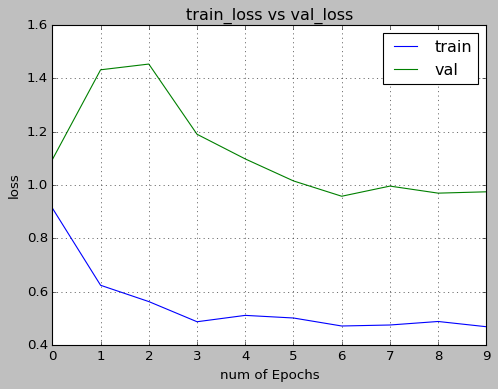

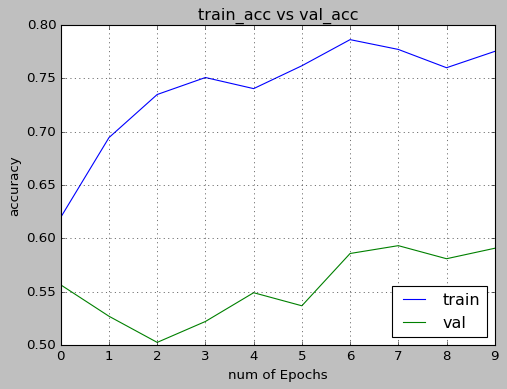

In [76]:
epochs = 10
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

A bit better result that here: https://www.kaggle.com/debasisdotcom/real-vs-fake-face-detection. Probably a bit bigger network on top of vgg16, or use of bigger network would improve the result. Helpful would also be adding even further regularization.